In [5]:
# Step 1 — Imports
import os, warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# (Optional) display settings
%matplotlib inline
sns.set(style="whitegrid")


In [2]:
# Step 2 — Load the CSV (use the iris.csv I created)
df = pd.read_csv("iris.csv")
print("Shape:", df.shape)
df.head()


Shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# Step 3 — Prepare features and (optional) true labels
X = df.iloc[:, 0:4].values      # feature columns
y_true = df['target'].values    # ground-truth species (0,1,2) for evaluation

# Standardize features (recommended for GMM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Step 4 — Fit Gaussian Mixture Model (EM)
# n_components: number of clusters (3 for Iris)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, init_params='kmeans', max_iter=200)
gmm.fit(X_scaled)

# Predicted cluster labels
y_pred = gmm.predict(X_scaled)

print("Converged:", gmm.converged_)
print("n_iter:", gmm.n_iter_)


Converged: True
n_iter: 11


In [7]:
# Step 5 — Inspect cluster sizes and means
unique, counts = np.unique(y_pred, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

# Cluster means in the scaled space (for interpretation convert back if needed)
print("Cluster means (scaled):\n", gmm.means_)


Cluster counts: {0: 98, 1: 45, 2: 7}
Cluster means (scaled):
 [[ 0.53745909 -0.39369142  0.6693573   0.64500292]
 [-0.93852253  0.98617415 -1.29410958 -1.24871335]
 [-1.53616188 -0.9148767  -1.05760659 -1.00758605]]


In [9]:
# Step 6 — Map cluster labels to true labels for evaluation (best matching)
# Since clustering labels are arbitrary, find mapping by majority vote per cluster
from scipy.stats import mode
import numpy as np

label_map = {}
for cluster in np.unique(y_pred):
    mask = (y_pred == cluster)
    if mask.sum() == 0:
        label_map[cluster] = -1
    else:
        m = mode(y_true[mask], keepdims=True)
        label_map[cluster] = int(m.mode[0] if hasattr(m.mode, "__getitem__") else m.mode)

mapped_preds = np.array([label_map[c] for c in y_pred])

print("Label mapping (cluster -> majority true label):", label_map)



Label mapping (cluster -> majority true label): {0: 2, 1: 0, 2: 0}


In [11]:
# Step 7 — Evaluation (confusion matrix & accuracy)
cm = confusion_matrix(y_true, mapped_preds)
acc = accuracy_score(y_true, mapped_preds)

print("\nConfusion Matrix:\n", cm)
print("\nAccuracy (after mapping): {:.4f}".format(acc))



Confusion Matrix:
 [[50  0  0]
 [ 2  0 48]
 [ 0  0 50]]

Accuracy (after mapping): 0.6667


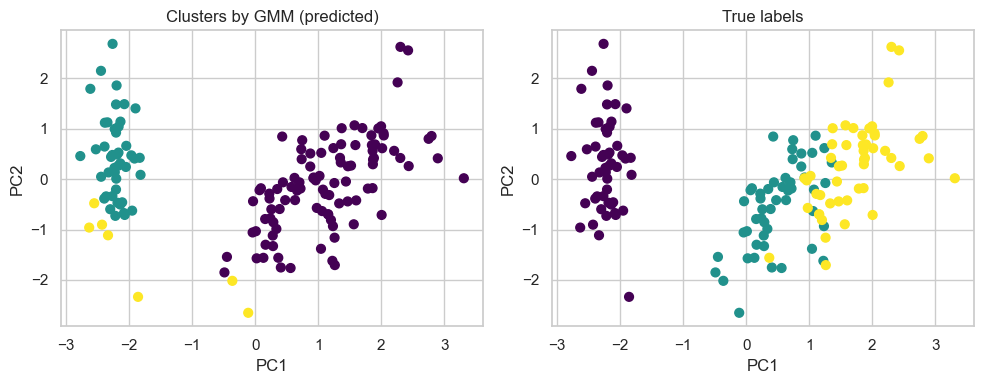

In [12]:
# Step 8 — Visualize clusters (2D scatter using first two principal components)
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Clusters by GMM (predicted)")
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap='viridis', s=40)
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.title("True labels")
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, cmap='viridis', s=40)
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()
